# Understanding and accessing `LINEAR` and `ZTF` data

*Authors: Ema Donev and dr. Ivezić*

This notebook contains all the information necessary to understand the data, its descriptive statistics, and how to plot light curves of both `LINEAR` and `ZTF` data.

In [21]:
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample

# ZTF
from ztfquery import lightcurve

# Basic libraries
import random
import pickle
import os
import sys

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd
import dask.dataframe as dd 

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# Multithreading/multiprocessing libraries
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
import threading

In [30]:
# CONFIG
sns.set_theme() # setting the theme for plotting
np.random.seed(42)

colors = ['#1A090D', '#D8C99B', '#D8973C', '#BD632F', '#273E47']
cmap = mcolors.ListedColormap(colors)

font = FontProperties()
font.set_family('avenir')
font.set_name('Avenir')
font.set_style('normal')
font.set_size('xx-large')

%matplotlib inline  

In [4]:
# Importing custom libraries
# ----------------------------
sys.path.insert(0,'../src/')
from ZTF_data import *
from config import*

# Downloading `LINEAR` and `ZTF` data

## `LINEAR` dataset

The `LINEAR dataset` *(Lincon Near-Earth Asteroid Research)* contains 7010 light curves of periodic variable stars. While the original mission of this survey was to find asteroids, it subsequently monitored a substantial portion of the sky, cataloging the brightness of various variable stars. This survey was operated with two telescopes on a site in New Mexico. The two telescopes are equatorially mounted of GEODSS type, where each telescope is denoted as L1 and L2. They observed a broad part of the visible spectrum and the near-infrared spectrum. 

The preprocessing process contained the following procedures:
1. **Bias correction**: removing noise created by the camera
2. **Flat-field correction**: removing artificial lines and gradients due to varying sensitivities of pixels
3. **Preliminary fixed-aperture photometry**: subtracting the background light using Poisson statistics

After preprocessing, the data had to be astrometrically recalibrated, meaning that the scientists had to ensure the coordinates of the objects in the data matched another survey, like SDSS. Of all the data, 7% had bad astrometry (the coordinates did not fit), so the scientists removed them from the dataset. The rest of the data had a 1-2% error in astrometry.

Next up was photometric recalibration, meaning that the filters and fluxes had to be recalibrated to match SDSS data. The corrections regarded CCD camera errors, correcting the magnitudes of objects in the data, and correcting underestimated magnitude errors. After the photometric recalibration, the data were grouped into various categories, including a variable star category. While the original dataset has 5 billion objects, *only 7010 are confirmed periodic variable stars*. The scientists subsequently analyzed this portion of the dataset by categorizing the light curves, calculating their periods, and inferring conclusions from the preceding factors. 

We can access the `LINEAR` dataset via one line of code since we are downloading the data from the AstroML library.

In [11]:
# LINEAR DATA
# ------------

dataL = fetch_LINEAR_sample(data_home='../inputs')
dataL

In [12]:
# acessing all of the light curves from the dataL and checking if any light curve is missing
c = 0 
for i in dataL.ids: # iterating through all of the dataL ID's
    light_curve = dataL.get_light_curve(i) # fetching the light curve dataL for a specific ID
    c += 1 
print(c) 

7010


The counter has printed the number `7010`, the correct amount of light curves in this dataset. No light curves are missing!

#### Structure of `LINEAR` dataset

The structure of the `LINEAR` dataset is as such:
- `dataL` is a `AstroML.datasets` object and it contains the following:
    - `dataL.ids` is a list of all the IDs of the stars
    - `dataL.get_light_curve()` is a function which acceses the data for a specific ID of a light curve
        - every light curve is a `np.array()` object where every column is `time`, `magnitude` and the `magnitude error`. In order to get an array for every column the original array must be transposed.
    - `dataL.targets` contains all of the metadata for every light curve eg. rectascension, declination, etc.

Here is an example of a light curve:

LINEAR ID:10003298
(10003298, 207.52946, 33.70615, 207.529404, 33.706001, 15.73, 1.84, 0.81, 0.31, 0.16, 0.63, 15.89, 0.16, 0.19, 1.12, -0.61, -0.01, -1, 0)
Rectascension:207.529404, and Declination:33.706001


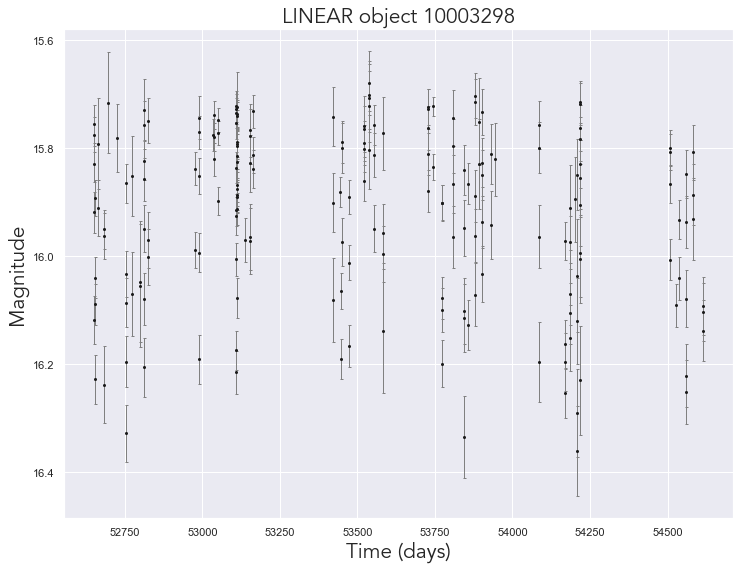

In [31]:
ID = dataL.ids[0] # accessing the first LINEAR ID
lc = dataL.get_light_curve(ID)
time, mag, magerr = lc.T # transposing the data
#--------
print(f'LINEAR ID:{ID}')
targets = dataL.targets[0]
print(targets)
ra, dec = targets[3], targets[4]
print(f'Rectascension:{ra}, and Declination:{dec}')
#--------
fig, ax = plt.subplots(1,1, figsize=(12,9)) # creating subplots with 2 columms and 3 rows
ax.errorbar(time, mag, magerr, fmt='.k', ecolor='gray',lw=1, ms=4, capsize=1.5)
ax.set_xlabel('Time (days)',fontproperties=font)
ax.set_ylabel('Magnitude', fontproperties=font)
ax.set_title('LINEAR object {0}'.format(ID), fontproperties=font)
ax.invert_yaxis()
plt.show()

For further analysis we will require the `LINEAR ID`, the `ra` and `dec` values, and finally, the data for every light curve (time, magnitude, errors).

### Introductory statistics of `LINEAR` data

In [33]:
# NUMBER OF MEASUREMENTS
# -----------------------
pL = []
for i in dataL.ids:
    lc = dataL.get_light_curve(i)
    t, m, me = lc.T
    pL.append(len(t))

total_obser = sum(pL) # summing the number of measurements of every light curve
print(total_obser)

1851936


Our dataset contains 1 851 936 observations!

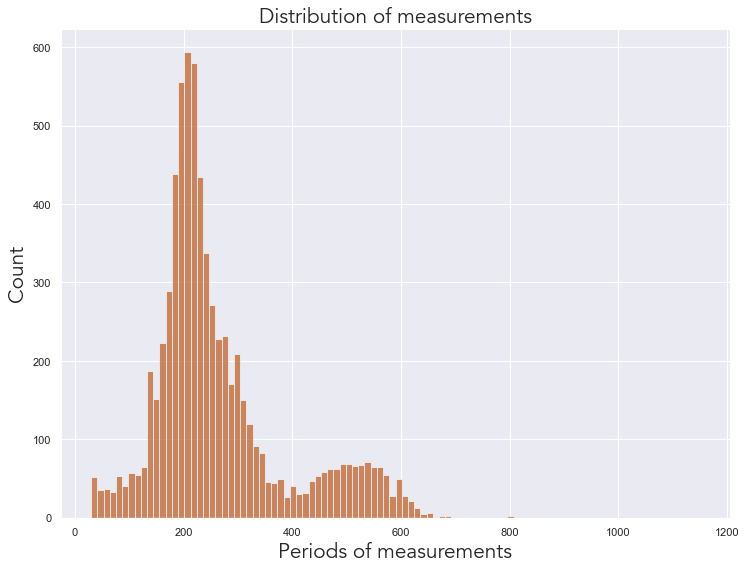

In [37]:
plt.figure(figsize=(12,9))
sns.histplot(data=pL,color='#BD632F') # drawing a histogram of the distribution of measurements
plt.title('Distribution of measurements', fontproperties=font)
plt.xlabel('Periods of measurements', fontproperties=font)
plt.ylabel('Count', fontproperties=font)
plt.show()

The graph above shows that most of our light curves have around 200 to 300 measurements, with a subsequent peak at about 500 measurements per light curve.

In [40]:
# TIME DIFFERENCE
tmL = []
for i in dataL.ids:
    lightc = dataL.get_light_curve(i)
    t, m, me = lightc.T
    time = t[len(t)-1] - t[0] # last time - first time
    tmL.append(time)

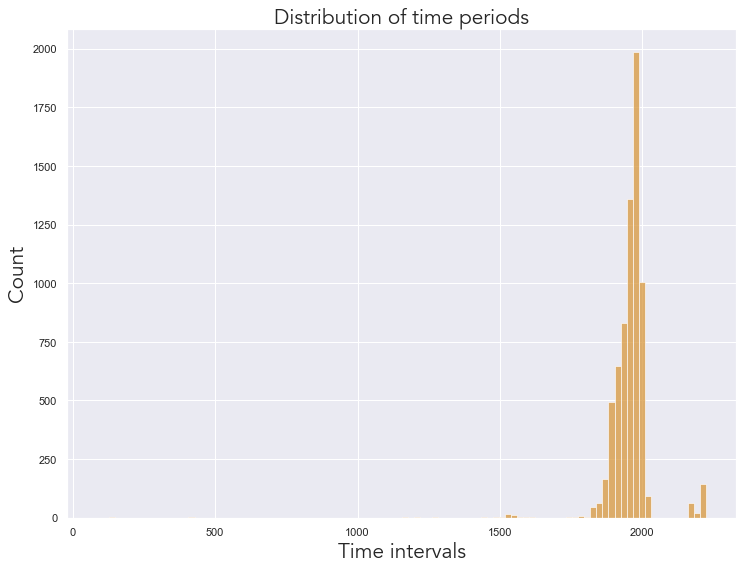

In [41]:
plt.figure(figsize=(12,9))
sns.histplot(data=tmL,color='#D8973C', bins=100)
plt.title('Distribution of time periods',fontproperties=font)
plt.xlabel('Time intervals',fontproperties=font)
plt.ylabel('Count', fontproperties=font)
plt.show()

This graph shows that most of our time intervals span around 1800 to 2000 days. So, no matter the variable star type, most actual time intervals are very long.

## `ZTF` dataset

The `Zwicky Transient Facility` is an optical time-domain survey that uses the Palomar 48-inch Schmidt telescope to observe the entire Northern hemisphere sky in 3 different bands: `g,` `r`, and `i`, and has been operating since October 2017. This telescope has a large field of view, taking in a lot of data.

All the data gathered by `ZTF` is stored at the IPAC, which can be accessed via IRSA, as shown in this project. All of the raw data was processed so that every pixel had an average of 5 bits, and although this increased sky noise by 1%, the increase is negligible. All the images were FITS images which the program processed in the following way:
1. **Preprocessing:** removing bias frames and flat field correction frames.
2. **Astrometry:** Using the `SCAMP` package, all objects were astrometrically calibrated to match the `GAIA` survey.
3. **Photometry:** All images were photometrically calibrated following the `PanSTARRS 1` survey.
4. **Final processing:** Finally, masks were made for saturation, bad pixels were removed, ghosts and any instrumental artifacts, and other defects.

Every image was then categorized as either a moving or a changing source using the `ZOGY` algorithm. Furthermore, point-like moving objects were identified using the custom `ZTF Moving-object Discovery Engine (ZMODE).` 

`ZTF` was able to observe the following objects:

**1. Transient objects**

These objects are supernovae found in other galaxies, and the `ZTF` survey captured their light curves.

**2. Neutrinos and gravitational-wave events**

The `ZTF` survey showed that scientists could use `ZTF` in the future to undertake observations of neutrinos and gravitational-wave events. 

**3. Variable objects**

These include variable stars but also light curves of asteroids. The light curves in the `ZTF`dataset were built upon every few months, and the light curves were stored in `HDF5` match files per each field of observation. `ZTF` contains many light curves, and some most notable types are *Be stars*, *RR Lyrae* stars, light curves of *NEOs*, *Asteroids*, and the activity of *Comets and Centaurs*.  

### Accessing the `ZTF` data

The `ZTF` data is on an extrenal API provided by the `IRSA` webpage. Since querying for the data takes a lot of time, we use **asynchronous** programming to tackle multiple queries at a time, significantly shortening the runtime. All light curves are searched by equatorial coordinates (found in `dataL.targets`) and saved as `DataFrames` inside an array, along with the search ID as a `tuple`. So, *array([(ID1, DataFrame object 1), (ID2, DataFrame object 2),...])*. All of the code can be found in the custom `ZTF_data.py` library.

In [42]:
ZTF_data = data_ztf('ZTF_light_curves.npy')

Loading the data!
